### Import libs

In [1]:
import pathlib
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

### Define paths

In [2]:
BASE_DIR = pathlib.Path().cwd()
DATASET_DIR = BASE_DIR / 'dataset'
ANNOTATIONS_DIR = DATASET_DIR / 'annotations'
IMAGES_DIR = DATASET_DIR / 'images'

### Funcs for making DataFrame

In [3]:
def get_object(obj):
    """Returns coordinates and mask status."""
    mask_status = obj.find('name').text
    x_min = int(obj.find('xmin').text)
    y_min = int(obj.find('ymin').text)
    x_max = int(obj.find('xmax').text)
    y_max = int(obj.find('ymax').text)
    return [mask_status, x_min, y_min, x_max, y_max]

In [4]:
def get_annotations(file):
    """Returns row for DataFrame."""
    with open(file) as f:
        data = f.read()
    soup = BeautifulSoup(data, 'xml')
    objects = soup.find_all('object')
    image_name = soup.find('filename').text
    size = [int(soup.find('width').text), int(soup.find('height').text)]
    row = [image_name, size, []]
    for obj in objects:
        row[2].append(get_object(obj))
    while len(row[2]) < 115:
        row[2].append(0)
    return row

In [5]:
def make_df(list_xlms):
    """Returns DataFrame from get_annotation()'s rows."""
    print('Make DataFrame... ', end='')
    dict_df = {'image': [], 'size': []}
    for file in list(list_xlms):
        row = get_annotations(file)
        dict_df['image'].append(row[0])
        dict_df['size'].append(row[1])
        for i in range(len(row[2])):
            try:
                dict_df[f'Object {i}'].append(row[2][i])
            except KeyError:
                dict_df[f'Object {i}'] = []
                dict_df[f'Object {i}'].append(row[2][i])
    df = pd.DataFrame(dict_df)
    print('Done!')
    return df

### Make DataFrame

In [6]:
df = make_df(ANNOTATIONS_DIR.glob('*.xml'))
print('Make images arrays... ', end='')
data = []
labels = []
for id, image in enumerate(IMAGES_DIR.glob('*.png')):
    img = load_img(image)
    for obj in df.columns[2:]:
        annotations = df[obj][id]
        if annotations != 0:
            coordinates = (annotations[1:])
            if (coordinates[2] - coordinates[0]) > 40 and (coordinates[3] - coordinates[1]) > 40:
                labels.append(annotations[0])
                mask = img.crop(coordinates)
                mask = mask.resize((224, 224))
                mask = img_to_array(mask)
                mask = preprocess_input(mask)
                data.append(mask)
print('Done!')

Make DataFrame... Done!
Make images arrays... Done!


### Bringing data and labels to correct view

In [7]:
data = np.array(data, dtype='float32')
np_arr_labels = np.array(labels)

In [46]:
lb = LabelEncoder()
labels = lb.fit_transform(np_arr_labels)
labels = to_categorical(labels)

### Augmentation

In [9]:
aug = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Design model

In [10]:
# Based on the MobileNetV2
baseModel = MobileNetV2(weights='imagenet', include_top=False, input_tensor = Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(64, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

### Hyperparameters

In [11]:
INIT_LR = 1e-4
EPOCHS = 30
BS = 1

### Split dataset

In [12]:
(train_x, test_x, train_y, test_y) = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

### Compile model

In [13]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Train model

In [14]:
H = model.fit(
    aug.flow(train_x, train_y, batch_size=BS),
	steps_per_epoch=len(train_x) // BS,
	validation_data=(test_x, test_y),
	validation_steps=len(test_x) // BS,
	epochs=EPOCHS
)

Epoch 1/30
579/579 [==============================] - 15s 25ms/step - loss: 0.4839 - accuracy: 0.8532 - val_loss: 0.2736 - val_accuracy: 0.9157

### Model's prediction and measurements

                       precision    recall  f1-score   support

mask_weared_incorrect       0.56      0.45      0.50        11
            with_mask       0.97      0.98      0.97       206
         without_mask       0.97      0.94      0.95        32

             accuracy                           0.95       249
            macro avg       0.83      0.79      0.81       249
         weighted avg       0.95      0.95      0.95       249



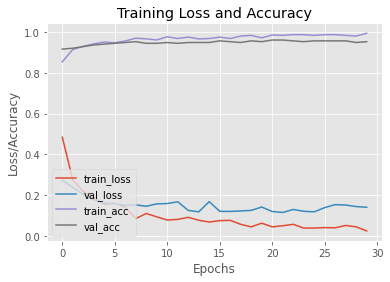

In [15]:
predict = model.predict(test_x, batch_size=32)
predict = np.argmax(predict, axis=1)

print(classification_report(test_y.argmax(axis=1), predict, target_names=lb.classes_))

plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, EPOCHS), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, EPOCHS), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, EPOCHS), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.show()

### Saving model

In [16]:
model.save('model.h5')

### User's predictions

In [60]:
img_with_mask = load_img(BASE_DIR / 'with_mask.jpg').resize((224, 224))

In [18]:
def preprocess_image(img):
    """Brings image to correct view for model."""
    img = img_to_array(img.resize((224, 224)))
    img = [preprocess_input(img)]
    return np.array(img, dtype='float32')

In [47]:
def predict(image):
    """Predicts and view image on plot."""
    plt.grid(False)
    plt.imshow(image)
    img = preprocess_image(image)
    predictions = model.predict(img)
    numeric_class = np.argmax(predictions[0])
    class_text = lb.fit(np_arr_labels).classes_[numeric_class]
    return f'Mask status: {class_text} | num_class: {numeric_class} | Accuracy: {np.max(predictions[0])*100:.2f}%'

'Mask status: with_mask | num_class: 1 | Accuracy: 99.98%'

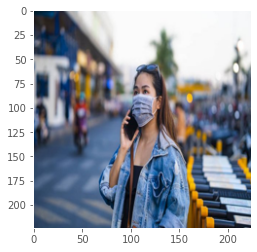

In [56]:
predict(img_with_mask)